In [12]:
import os
import glob
import torch
import minari

import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns

import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchdyn.core import NeuralODE

from tqdm import tqdm
from natsort import natsorted

In [13]:
print(f"Torch version: {torch.__version__}")
print(f"Torch cuda version: {torch.version.cuda}")

Torch version: 2.6.0
Torch cuda version: 12.6


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [15]:
def collate_fn(batch):
    '''
    Pads the trajectories such that they all have the same length as the longest one (e.g. 178)
    '''
    observations = [torch.as_tensor(x.observations['observation']) for x in batch]
    lengths = torch.tensor([obs.shape[0] for obs in observations])  # Tensor of original lengths
    # Pad with zeros first
    padded_obs = torch.nn.utils.rnn.pad_sequence(observations, batch_first=True)

    # Use advanced indexing to replace padding with the last valid value
    mask = torch.arange(padded_obs.shape[1]).expand(len(batch), -1) >= lengths.unsqueeze(1)
    padded_obs[mask] = padded_obs[torch.arange(len(batch)), lengths - 1].unsqueeze(1).expand_as(padded_obs)[mask]

    return {
        "observations": padded_obs
    }

In [16]:
dataset = minari.load_dataset('D4RL/pointmaze/umaze-v2')
print(f"Total amount of episodes: {dataset.total_episodes}") 
batch_size = 64

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
# print(len(dataLoader)) # Total episodes / batch_size
for batch in dataLoader:
    test_batch = batch['observations']
    print(f"test_batch.shape: {test_batch.shape}")
    break

Total amount of episodes: 13210
test_batch.shape: torch.Size([64, 174, 4])


In [17]:
x_start = test_batch[:, 0, :]   # Initial points
x_end = test_batch[:, -1, :]    # Final points

# Compute standard deviation of displacement
sigma_init = 0.5 * torch.std(x_end - x_start).item()  # Scale by 0.5 as a heuristic

print("Initial sigma:", sigma_init)

Initial sigma: 1.6495187097945563


## Dataset trajectory example
* One episode
* Based on the 'Observation' parameter of Observations.

In [18]:
print(test_batch[0].shape)
print(test_batch[0, :, 0].shape)
print(len(test_batch[1]))

torch.Size([174, 4])
torch.Size([174])
174


Total duplicate points: 1
Duplicate points and their counts: {(np.float64(-0.5593624595713489), np.float64(0.9681064274796957)): 52}


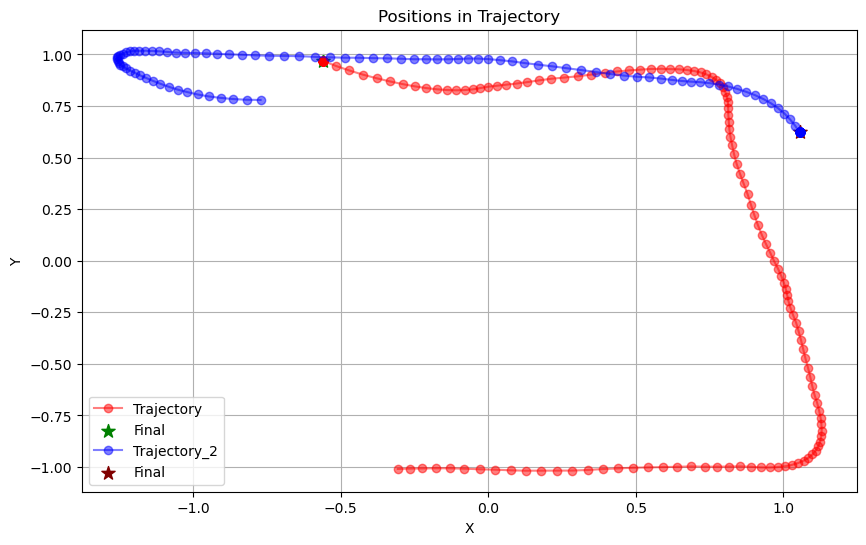

In [19]:
from collections import Counter
idx = 0 
trajectory = test_batch[idx].cpu().numpy()
trajectory_2 = test_batch[idx+1].cpu().numpy()
traj_tuples = [tuple(point[:2]) for point in trajectory]  # Only (x, y) positions

# Count occurrences
counts = Counter(traj_tuples)

# Filter duplicates (points appearing more than once)
duplicates = {point: count for point, count in counts.items() if count > 1}

print(f"Total duplicate points: {len(duplicates)}")
print("Duplicate points and their counts:", duplicates)

plt.figure(figsize=(10, 6))

plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', color='red', alpha=0.5, label="Trajectory")
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], marker='v', color='green',s=100, alpha=1, label="Final")

plt.plot(trajectory_2[:, 0], trajectory_2[:, 1], marker='o', color='blue', alpha=0.5, label="Trajectory_2")
plt.scatter(trajectory_2[-1, 0], trajectory_2[-1, 1], marker='v', color='maroon',s=100, alpha=1, label="Final")

plt.title('Positions in Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

## FLOW MATCHING

In [20]:
import torch
import torch.nn as nn

class TrajectoryFlowModel(nn.Module):
    def __init__(self, obs_dim, hidden_dim=256, num_layers=5):
        """
        A neural network that estimates the velocity field for flow matching.

        Args:
            obs_dim (int): Dimensionality of observations (D_obs)
            hidden_dim (int): Number of hidden units in the MLP
            num_layers (int): Number of layers in the MLP
        """
        super().__init__()

        layers = []
        input_dim = obs_dim + 1  # We include time `t` as an input
        
        for i in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            
            # Alternating activation functions for better gradient flow and expressivity
            if i % 2 == 0:
                layers.append(nn.SiLU())  # Swish/SiLU for smoothness
            else:
                layers.append(nn.ReLU())  # ReLU for stability
            
            input_dim = hidden_dim 
        
        layers.append(nn.Linear(hidden_dim, obs_dim))  # Output layer, no activation
        self.network = nn.Sequential(*layers)

    def forward(self, xt):
        """
        Forward pass for the trajectory flow model.
        """
        velocity = self.network(xt) 
        return velocity


In [31]:
lr = 3e-3
traj_dim = 4 # [xpos, ypos, xvel, yvel]
flow_model = TrajectoryFlowModel(traj_dim).to(device)
optimizer = torch.optim.AdamW(flow_model.parameters(), lr=lr)

In [32]:
# Define input tensor
batch_size = 64  # Example batch size
obs_dim = 4
xt = torch.randn(batch_size, obs_dim + 1).to(device, dtype=torch.float32)  # Adding time `t` as an input feature

# Forward pass
velocity_pred = flow_model(xt)

# Check shapes
print(f"Input shape: {xt.shape}")  # Expected: (64, 5)
print(f"Output shape: {velocity_pred.shape}")  # Expected: (64, 4)

# Define a dummy target velocity tensor
target_velocity = torch.randn_like(velocity_pred)

# Compute loss
loss_fn = nn.MSELoss()
loss = loss_fn(velocity_pred, target_velocity)

# Backpropagation
loss.backward()

# Check if gradients are computed
for name, param in flow_model.named_parameters():
    if param.grad is None:
        print(f"Gradient not computed for {name}")
    else:
        print(f"Gradient exists for {name} with shape {param.grad.shape}")


Input shape: torch.Size([64, 5])
Output shape: torch.Size([64, 4])
Gradient exists for network.0.weight with shape torch.Size([256, 5])
Gradient exists for network.0.bias with shape torch.Size([256])
Gradient exists for network.2.weight with shape torch.Size([256, 256])
Gradient exists for network.2.bias with shape torch.Size([256])
Gradient exists for network.4.weight with shape torch.Size([256, 256])
Gradient exists for network.4.bias with shape torch.Size([256])
Gradient exists for network.6.weight with shape torch.Size([256, 256])
Gradient exists for network.6.bias with shape torch.Size([256])
Gradient exists for network.8.weight with shape torch.Size([4, 256])
Gradient exists for network.8.bias with shape torch.Size([4])


In [33]:
for _ in range(3):
    xt = torch.randn(batch_size, obs_dim + 1).to(device)
    velocity_pred = flow_model(xt)
    print(f"Velocity Prediction Sample: {velocity_pred[_]}")
    print(f"Shape: {velocity_pred[_].shape}")


Velocity Prediction Sample: tensor([-0.0539,  0.0357, -0.0254, -0.0242], device='cuda:0',
       grad_fn=<SelectBackward0>)
Shape: torch.Size([4])
Velocity Prediction Sample: tensor([-0.0559,  0.0420, -0.0071, -0.0460], device='cuda:0',
       grad_fn=<SelectBackward0>)
Shape: torch.Size([4])
Velocity Prediction Sample: tensor([-0.0662,  0.0349, -0.0019, -0.0172], device='cuda:0',
       grad_fn=<SelectBackward0>)
Shape: torch.Size([4])


In [22]:
observation_lst = []
max_batches = 20
for count, batch in enumerate(dataLoader):
    if count == max_batches:
        break
    obs = batch['observations']
    observation_lst.append(obs)

In [48]:
def compute_mu_t(x1, t):
    '''
    Calculates the mean, according to Eq.20 in Lipman 2023
    '''
    return t * x1

In [34]:
def compute_sigma(t, sigma):
    '''
    Calculates the standard deviation, sigma, according to Eq. 20 in Lipman 2023
    '''
    sigma = 1 - (1 - sigma) * t
    return sigma

In [25]:
def compute_conditional_vector_field(x0, x1, t, xt, sigma):
    '''
    Calculates the conditional velocity field u_t defined by Eq. 21 in Lipman 2023.
    The corresponding conditional flow: Eq.22
    '''
    # return x1 - x0 # For "normal" CFM
    t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
    return (x1 - (1 - sigma) * xt) / (1 - (1 - sigma) * t_expanded) # Eq. 21, Lipman 2023

In [56]:
def sample_xt(x0, x1, t, sigma):
    ''' 
    xt is the flow model (satisfies boundary conditions Eq 4.6 Lipman 2024)
    Equals conditional phi in Lipman 2024
    '''
    sigma = compute_sigma(t, sigma)
    epsilon = torch.randn_like(x0).to(device=x0.device, dtype=torch.float32)
    t_expanded = t[:, None, None].expand(-1, x1.shape[1], -1)
    mu_t = compute_mu_t(x1, t_expanded)
    sigma = sigma[:, None, None].expand(-1, x1.shape[1], -1)
    
    return mu_t + sigma * epsilon # Eq. 4.50 in Lipman 2024?

In [27]:
def sample_and_compute(x0, x1, t, sigma):
    
    xt = sample_xt(x0, x1, t, sigma) # Flow model
    ut = compute_conditional_vector_field(x0, x1, t, xt, sigma) # Velocity field

    return t, xt, ut

In [28]:
class torch_wrapper(nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, xt, *args, **kwargs):
        # t = t.repeat(x.shape[0])[:, None, None] # Repeats t along first dim, [batch_size, 1, 1]
        return self.model(xt)

In [29]:
def single_gaussian_sample_alt(batch_size, sec_dim, traj_dim, sigma, device=device, var=1.0):
    """
    Generate samples from a single Gaussian distribution centered at the origin.

    Args:
        batch_size (int): Number of batches.
        sec_dim (int): Number of sections (sequence length).
        traj_dim (int): Dimensionality of each trajectory point.
        var (float): Variance of the Gaussian distribution.

    Returns:
        torch.Tensor: Tensor of shape (n, dim) containing sampled points.
    """

    
    single_sample = torch.randn(batch_size, sec_dim, traj_dim) * var**0.5
    return single_sample.to(device, dtype=torch.float32)

## Training

In [57]:
num_epochs = 5

  
save_path = "fm_model_checkpoint.pth"
xt_prog = []
losses = []

sigma = sigma_init # How much noise is added when interpolating, calculated earlier

lr = 3e-3
traj_dim = 4 # [xpos, ypos, xvel, yvel]
flow_model = TrajectoryFlowModel(traj_dim).to(device)
optimizer = torch.optim.AdamW(flow_model.parameters(), lr=lr)


for epoch in range(num_epochs):
    for batch in tqdm(dataLoader, desc=f"Training Progress"):
        observations = batch['observations'].to(device)
        x1 = observations
        x0 = torch.rand_like(x1).to(device)
        t = torch.rand((x1.shape[0],), device=device)

        t, xt, ut = sample_and_compute(x0, x1, t, sigma)
        # xt = sample_conditional_pt(x0, x1, t, sigma=sigma).to(device, dtype=torch.float32)
        # ut = compute_conditional_vector_field(x0, x1, t, xt, sigma=sigma).to(device, dtype=torch.float32)

        t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
        xt = torch.cat([xt, t_expanded], dim=-1).to(device, dtype=torch.float32)
        # xt = xt.to(device, dtype=torch.float32)
        vt = flow_model(xt)

        loss = torch.mean((vt - ut) ** 2)
        loss = loss.to(device, dtype=torch.float32)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    # Save checkpoint after each epoch
    checkpoint = {
        'model_state_dict': flow_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'learning_rate': lr,
        'sigma': sigma,
        'vt': vt
    }

    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved to {save_path} after epoch {epoch + 1}")

Training Progress: 100%|██████████| 206/206 [03:10<00:00,  1.08it/s]


Checkpoint saved to fm_model_checkpoint.pth after epoch 1


Training Progress:  23%|██▎       | 47/206 [00:35<02:05,  1.27it/s]

In [ ]:
save_path = "fm_model_checkpoint.pth"
checkpoint = torch.load(save_path, map_location=device)

flow_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint.get('losses', [])
lr = checkpoint['learning_rate']
sigma = checkpoint['sigma']
vt = checkpoint['vt']

print("Checkpoint loaded successfully!")

Checkpoint loaded successfully!


In [ ]:
def plot_trajectories(traj, batch_size, observation_lst):
    """Plot trajectories of some selected samples."""
    print(f"Plot trajs: traj shape {traj.shape}")
    n = batch_size  # Batch_size
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black", label="Noisy Sample")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="red", label="Flow")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue", label="Target Sample")
    # for observations in observation_lst:
    #     plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)  
    plt.legend()
    plt.title("Flow Matching Evolution")
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [ ]:
def sample_and_plot(flow_model, batch_size, xt, traj_dim, sigma, observation_lst, solver="dopri5"):
    node = NeuralODE(
        torch_wrapper(flow_model), solver=solver, sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            single_gaussian_sample_alt(batch_size, xt.shape[1], traj_dim, sigma),
            t_span = torch.linspace(0, 1, 100, device=device, dtype=torch.float32),
        )
        plot_trajectories(traj.cpu().numpy(), batch_size, observation_lst)

In [ ]:
sample_and_plot(flow_model, batch_size, xt, traj_dim, sigma, observation_lst)
print(f"Shape of x1 {x1.shape}\n{x1}")

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (27776x4 and 5x256)

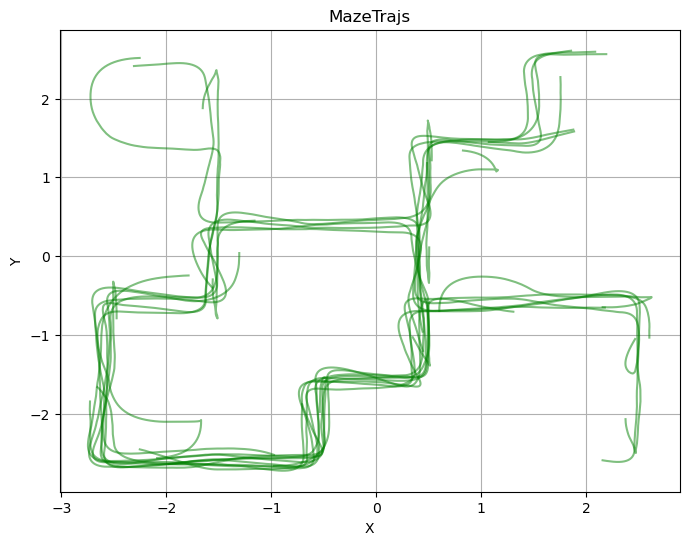

In [ ]:
plt.figure(figsize=(8, 6))
for observations in observation_lst:
    plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)
plt.title('MazeTrajs')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

# Load model

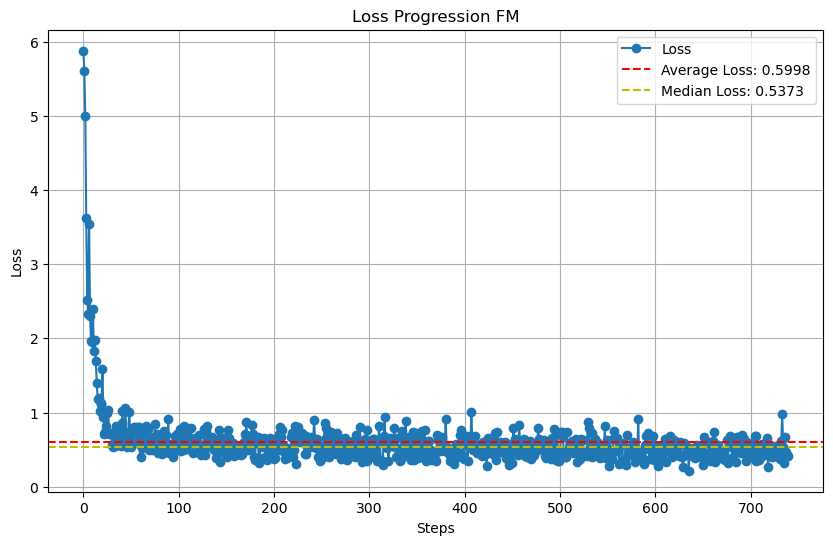

In [ ]:
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

# losses[2] = med_loss
# print(losses)

save_dir = 'Plotted loss'
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, 'loss_plot.png')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss', marker='o')
plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
plt.axhline(y=med_loss, color='y', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
plt.title('Loss Progression FM')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()